# **Modelling, testing & Evaluation**

In this part, I am going to tune and build a few algorithms to predict the Accident Severity in the UK in order to improve the road safety in the country. 

First of all we are going to import all the libraries and modules we will use during the analys. 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns 
import time 
import os
from joblib import dump
from joblib import load

from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import precision_recall_fscore_support, plot_confusion_matrix, plot_precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

We can now read the training and testing set, which have been cleaned and transformed in the first part of the project. 

In [2]:
#load the training set 
train_set = pd.read_csv("final_trainset.csv")

#load the testing set 
test_set = pd.read_csv("final_testset.csv")

In [3]:
#print the shape of training and testing set 
print(f"train shape: {train_set.shape}\ntest shape: {test_set.shape}")

train shape: (93978, 35)
test shape: (23495, 35)


In [4]:
#chech the dataset 
train_set.loc[:5,].style

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Number_of_Vehicles,Speed_limit,high_winds,Monday,Saturday,Sunday,Thursday,Tuesday,Wednsday,One way street,Roundabout,Single carriageway,Slip road,Darkness - No lighting,Daylight,Snow,Water,None,Road Defect,Urban,Spring,Summer,Winter,Morning,Night,Road Hazard,Fog or mist,Other,Raining,Snowing,Accident_Severity
0,-1.442574,2.079796,-1.556315,2.064596,-1.000000,0.000000,True,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,Slight
1,0.370081,1.005455,0.398955,1.001380,-1.000000,-1.000000,False,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Slight
2,-0.698771,-0.202495,-0.706757,-0.194844,-1.000000,0.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Slight
3,0.560456,-0.225449,0.545707,-0.225843,1.000000,-1.000000,False,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Slight
4,0.373136,0.722523,0.391836,0.720016,-1.000000,3.000000,False,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,Slight
5,-0.849369,1.609635,-0.892327,1.606573,0.000000,0.000000,False,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,Serious


Before proceding with the models' building we need to set up what will be our predictors and target features. Hence, we create two subsets both for training and testing the predictive models, in which we will have our predictors and our taget variable seperated.

Also, we will not look at the test set until the evaluation stage. 

In [5]:
#Create X and y from the training set 
X_train = train_set.drop("Accident_Severity", axis = 1)
y_train = train_set["Accident_Severity"].copy()

#Create X and y from the testing set 
X_test = test_set.drop("Accident_Severity", axis = 1)
y_test = test_set["Accident_Severity"].copy()

In [6]:
print(f"Predictors: {X_train.shape}\nTarget Variable: {y_train.shape}")

Predictors: (93978, 34)
Target Variable: (93978,)


## Contruction of Predictive Features - Feature Selection 

The training set has got 34 features, so we can try to extract the most important features in predicting our target variable instead of using all of them. Doing so, we will simplify the model as weel as filtering out the least important features related to our target variable. 

### Embedded Method 

Embedded methods focus on which features best contribute to the accuracy of the model while the model is being created. These kinds of methods have built-in feature importance evaluation mechanism, and include feature selection inside the training process. 

In scikit-learn, there is a class named as SelectFromModel for implementing embedded methods for feature selection.

The algorithm we are going to use is the Random Forest Classifier and since our target has inbalanced classes, we will set the `class_weight` parameter to "balanced". Doing so, the algorithm itself will assign weights to each classes in order to make them balanced. 

In [11]:
rfc = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1)

param_grid = {
        'n_estimators': [100, 200, 500],
        'max_depth': [5, None]
}


# we'll use 10-fold cross-validation
rfc_grid_search = GridSearchCV(rfc, param_grid, cv=5, 
                              scoring='accuracy',return_train_score=True, n_jobs=-1)

start = time.time()
rfc_grid_search.fit(X_train, y_train)
end = time.time() - start
print(f"Took {end} seconds")

Took 139.09525680541992 seconds


In [12]:
#Best estimators from the grid search 
rfc_grid_search.best_estimator_

RandomForestClassifier(class_weight='balanced', n_estimators=500, n_jobs=-1,
                       random_state=42)

In [13]:
#check the average accuracy over the five k-fold 
rfc_grid_search.best_score_

0.7803528607316051

The best tuned model in the gridsearch achieved an accuracy of **78.03%**

The Random Forest itself is able to retrieve the importance of each features used within the model. We can check this out using the attribute `feature_importances_`

In [14]:
# put them into a separate variable for convenience
feature_importances = rfc_grid_search.best_estimator_.feature_importances_

# the order of the features in `feature_importances` is the same as in the Xtrain dataframe,
# so we can "zip" the two and print in the descending order:

for k, v in sorted(zip(feature_importances, X_train.columns), reverse=True):
    print(f"{v}: {k}")

Location_Northing_OSGR: 0.15383945878340258
Latitude: 0.15336917486224783
Longitude: 0.1509861389968168
Location_Easting_OSGR: 0.15066790450207862
Speed_limit: 0.05547394685413158
Number_of_Vehicles: 0.04235002043853137
Urban: 0.021919707504145014
Water: 0.018521364288798612
Spring: 0.017556660768707766
Summer: 0.017305405457335735
Winter: 0.017287891535003066
Morning: 0.015900014463931755
Single carriageway: 0.015153215793314127
Night: 0.01492171437128286
Wednsday: 0.014846406462398376
Saturday: 0.014660705616174495
Thursday: 0.014546614496035093
Tuesday: 0.014286090961892657
Sunday: 0.014056281825067891
Daylight: 0.012899569296700945
Monday: 0.012888801741315112
Raining: 0.012393684452587272
Darkness - No lighting: 0.009743897981085855
Roundabout: 0.006444687865473881
high_winds: 0.005454421147402635
Road Defect: 0.004355242035898601
Other: 0.0042263415094134366
None: 0.0034370928204272622
Slip road: 0.0029654466216081114
One way street: 0.002618521000968236
Road Hazard: 0.0020957398

Since the model took a while to be trained, we can save it in memory. 

In [ ]:
# create a folder where all trained models will be kept
if not os.path.exists("models"):
    os.makedirs("models")

#Save the model
dump(rfc_grid_search.best_estimator_, 'models/rf-clf.joblib')

In [7]:
#load the model 
rfc = load('models/rf-clf.joblib')

We can now use the embedded method to select the most important features in our training. The threshold has been set up as the "median", thereby we are expecting to get the **17 most important features.**

In [8]:
#instatate the method
sel_sfm = SelectFromModel(rfc, prefit=True, threshold="median")

#acces the selected features 
sel_sfm_index = sel_sfm.get_support()

#select all the selected features from the original dataset for the training 
X_train_sfm = X_train.iloc[:, sel_sfm_index]

#print the selected features 
print(f"Selected features: \n{X_train_sfm.columns}")

#number of features 
print(f"\nNumber of features: {len(X_train_sfm.columns)}")

Selected features: 
Index(['Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude',
       'Latitude', 'Number_of_Vehicles', 'Speed_limit', 'Saturday', 'Thursday',
       'Wednsday', 'Single carriageway', 'Water', 'Urban', 'Spring', 'Summer',
       'Winter', 'Morning', 'Night'],
      dtype='object')

Number of features: 17


We are going to extract those features from the testing set as well. 

In [9]:
#select all the selected features from the original dataset  for the testing set as well 
X_test_sfm = X_test.iloc[:, sel_sfm_index]

#print the selected features 
print(f"Selected features: \n{X_test_sfm.columns}")

#number of features 
print(f"\nNumber of features: {len(X_test_sfm.columns)}")

Selected features: 
Index(['Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude',
       'Latitude', 'Number_of_Vehicles', 'Speed_limit', 'Saturday', 'Thursday',
       'Wednsday', 'Single carriageway', 'Water', 'Urban', 'Spring', 'Summer',
       'Winter', 'Morning', 'Night'],
      dtype='object')

Number of features: 17


## Baseline method

We'll use a majority class classifier as a baseline, i.e., we will find out what is the most common class label in the training set and always output it as a prediction.

In [7]:
#Check the number of instances belonging to each class
train_set["Accident_Severity"].value_counts()

Slight     73922
Serious    18730
Fatal       1326
Name: Accident_Severity, dtype: int64

In [8]:
#Total number of instances in the training set 
train_set.shape[0]

93978

The baseline classifier will output "Slight" for all predictions. We will use macro-averaging in this project (precision, recall and F-score are evaluated in each class separately and then averaged across classes). So if we can calculate the baseline classifier to all of the training set.

In [9]:
#true positives divided by total number of elements labelled as belonging to the positive class
slight_precision = round(train_set["Accident_Severity"].value_counts()[0]/train_set.shape[0], 3) 

#true positives divided by the total number of elements that actually belong to the positive class
slight_recall = round(train_set["Accident_Severity"].value_counts()[0]/train_set["Accident_Severity"].value_counts()[0],3) 

slight_fscore = round(2/(1/slight_precision + 1/slight_recall), 3) 

print(f"Precision: {slight_precision}")
print(f"Recall: {slight_recall}")
print(f"F-score: {slight_fscore}")

Precision: 0.787
Recall: 1.0
F-score: 0.881


In [10]:
print(f"Average Precision: {round(np.mean([slight_precision, 0, 0]), 3)}")
print(f"Average Recall: {round(np.mean([slight_recall, 0, 0]), 3)}")
print(f"Average F-score: {round(np.mean([slight_fscore, 0, 0]), 3)}")

Average Precision: 0.262
Average Recall: 0.333
Average F-score: 0.294


For the "Slight" label, the accuracy measures will be:

* Precision: 73922/93978 = 0.787

* Recall: 73922/73922 = 1.0

* F-score: 2/(1/precision + 1/recall) = 0.881

For the "Serious" label, it will be:

* Precision: 0.0/0.0 = 0.0

* Recall: 0.0/18730 = 0.0

* F-score: 0.0

For the "Fatal" label, it will be:

* Precision: 0.0/0.0 = 0.0

* Recall: 0.0/1326 = 0.0

* F-score: 0.0

The averages of the three classes, i.e. the eventual baseline scores:

* **Precision: 0.262**

* **Recall: 0.333**

* **F-score: 0.294**

## Hyperparameter tuning

We are now going to tune hyperparameters for different models on the training set, to get the best possible model to use on the testing set. 

### Logistic Regression - Class Weights

The first model will be a Logistic Regression. Since we are dealing with an imbalanced class problem, I am going to balance each classes applying weights to them. Also, we are going to tune the regularisation parameter C using the L2 penalty. 

In [21]:
#instantiate the logistic regresison 
lr = LogisticRegression(penalty = 'l2', class_weight='balanced', multi_class='multinomial', random_state=42, n_jobs=-1)

#set the parameter we want to tune 
param_grid = {
            'C': [0.01, 0.1, 0.5, 1]
}

#instantiate the gridsearch cv using 5 k-folds 
lr_wt_grid = GridSearchCV(lr, param_grid, cv=5, 
                           scoring='f1_macro',return_train_score=True, n_jobs=-1)

#Fit the model 
start = time.time()
lr_wt_grid.fit(X_train_sfm, y_train)
end = time.time() - start
print(f"Took {end} seconds")

Took 10.528551816940308 seconds


The model best value for C appears to be 0.01, achieving a F-score of approximately **0.3314.**

In [22]:
lr_wt_grid.best_params_

{'C': 0.01}

In [23]:
lr_wt_grid.best_score_

0.3313937205537968

Since the model took a considerable amoun of time to be trained, we can save it on memory. 

In [32]:
dump(lr_wt_grid.best_estimator_, 'models/cw-lr.joblib')

['models/cw-lr.joblib']

### Random Forest - Class Weights 

We can now perform a Decision Tree Classifier to predict the Accident Severity. 

Furthermore, we know from the Random Forest Classifier GrisdSearch CV used in the embedded method, that the best `n_estimators` hyperparameter was the maximum we specified within the GridSearch CV, 500 trees. 

Hence, we might want to try to test if the model will pick up even a higher number of estimators. Following, the same happend for the `max_depth` hyperparameter, which between 5 and none, it chose none. 

Let's try to use this information in the next Random Forest Classifier.  

In [51]:
#Instantiate the model setting the weights
rfc_cw = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1, bootstrap=True)

#Hyperparameters grid to be tuned
param_grid = {
        'n_estimators': [500, 600, 700],
        'max_depth': [10, 15, None], 
        'criterion': ["gini", "entropy"]
}


# we'll use 5-fold cross-validation
rfc_cw_grid = GridSearchCV(rfc_cw, param_grid, cv=5, 
                              scoring='f1_macro',return_train_score=True, n_jobs=-1)

#Fit the model 
start = time.time()
rfc_cw_grid.fit(X_train_sfm, y_train)
end = time.time() - start
print(f"Took {end} seconds")

Took 1420.0020368099213 seconds


The best model parameteres are: `criterion` = 'entropy', `max_depth` = 15 and `n_estimators` = 700. The F-score achieved using this model is approximately **0.3843**, which is higher than both the baseline and the Logistic Regression. Hence for now, this is the best model we got. 

In [52]:
rfc_cw_grid.best_params_

{'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 700}

In [53]:
rfc_cw_grid.best_score_

0.3842298735514074

We can also check the performance on the cross validation training and testing set from the gridsearchCV alongside each of the hyperparameters combination we wanted to try out. 

In [54]:
val_scores = rfc_cw_grid.cv_results_["mean_test_score"]
train_scores = rfc_cw_grid.cv_results_["mean_train_score"]
params = rfc_cw_grid.cv_results_["params"]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params)):
    print(val_score, train_score, param)

0.31878189718237426 0.9999888472743279 {'criterion': 'gini', 'max_depth': None, 'n_estimators': 700}
0.3187885019681308 0.9999888472743279 {'criterion': 'gini', 'max_depth': None, 'n_estimators': 600}
0.3189153758592646 0.9999888472743279 {'criterion': 'gini', 'max_depth': None, 'n_estimators': 500}
0.3202838313685664 0.9999888472743279 {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 700}
0.3206175092620052 0.9999888472743279 {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 600}
0.3206739604872486 0.9999888472743279 {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 500}
0.37238310605774577 0.44612243330994883 {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 500}
0.37264103745981464 0.44583544675188963 {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 600}
0.37265634174118545 0.44609940045692864 {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 700}
0.3748711185330901 0.4569823105579257 {'criterion': 'gini', 'max_depth': 10, 'n_e

As we might have expected, the Random Forest Classifier tends to overfit the training set, losing the ability to generalise on unseen data. This happened especially with high number of estimators as well as allowing the tree to grow with any restiction. Indeed, we have reached the higher F-score using 15 for `max_depth` and 700 as `n_estimators`. However, the F-score it is only 0.384 while the baseline the baseline one is 0.294. It is, indeed, a better result but we might want to get a better result from the modl.  

We can also check what are most important features for the algorithm in predicting the accident severity. 

In [19]:
# put them into a separate variable for convenience
feature_importances =  rfc_cw_grid.feature_importances_

# the order of the features in `feature_importances` is the same as in the Xtrain dataframe,
# so we can "zip" the two and print in the descending order:

for k, v in sorted(zip(feature_importances, X_train.columns), reverse=True):
    print(f"{v}: {k}")

Location_Northing_OSGR: 0.1630370759851003
Latitude: 0.16288174956028617
Location_Easting_OSGR: 0.1586143236212207
Longitude: 0.15820184753761043
Speed_limit: 0.08372663594117816
Number_of_Vehicles: 0.06004902537950708
Tuesday: 0.0329875178195316
Slip road: 0.023569846734940884
Thursday: 0.02130693344565921
Sunday: 0.019108817710322606
One way street: 0.017963498889757075
Roundabout: 0.017458941944746367
Wednsday: 0.016544800105960395
high_winds: 0.016441746954827124
Saturday: 0.016239795382477214
Single carriageway: 0.01599607780346415
Monday: 0.015871365183410577


Let's create a bat plot for the feature importance using `Seaborn` to better visualise them. 

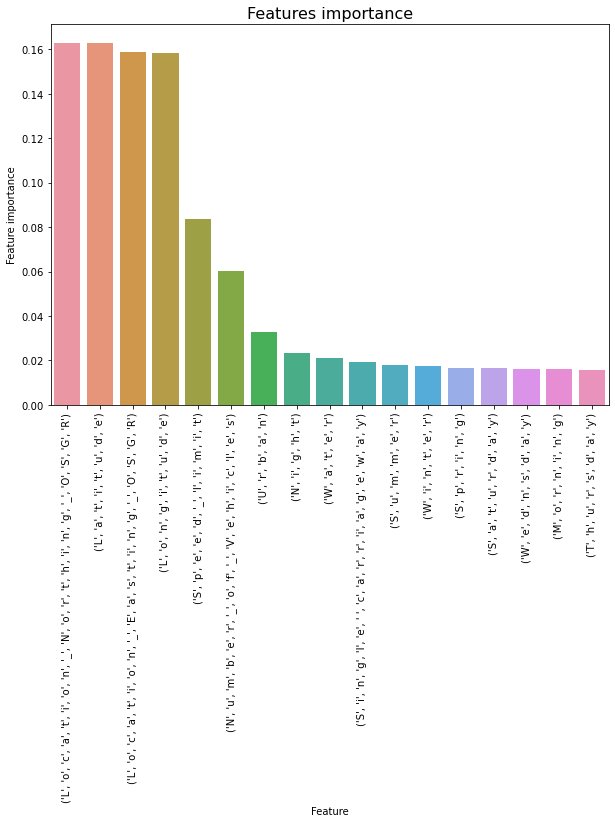

In [20]:
#Dataframe containing features in the training set and the mmodel feature imporacnce
tmp = pd.DataFrame({'Feature': X_train_sfm, 'Feature importance': rfc_cw_grid.feature_importances_})

#fort the feature importance in descending order 
tmp = tmp.sort_values(by='Feature importance',ascending=False)

#create the bar plot 
plt.figure(figsize = (10,7))
plt.title('Features importance',fontsize=16)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

Every location measure appears to be quite important for the model in predicting the accident severity as well as the speed limit and the number of vehicles involved in the accident. On the other hand, the days of the week do not seem to be relevant.

In [55]:
#save the model 
dump(rfc_cw_grid.best_estimator_, 'models/cw-rf-clf.joblib')

['models/cw-rf-clf.joblib']

Due to the fact that from the gridsearch the best `n_estimators` chose was the highest we specified, might be worth to try out a new gridsearchCV looking for an even higher number of trees. However, due to the fact that the Random Forest Classifier we have just tuned took around 23 minutes to be trained, we are going to perform two separate gridsearch to make the process a little bit faster. 

In [25]:
#Instantiate the model setting the weights
rfc_cw2 = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1, bootstrap=True)

#Hyperparameters grid to be tuned
param_grid = {
        'n_estimators': [700, 800],
        'max_depth': [15, 20], 
        'criterion': ["entropy"]
}


# we'll use 5-fold cross-validation
rfc_cw_grid2 = GridSearchCV(rfc_cw2, param_grid, cv=5, 
                              scoring='f1_macro',return_train_score=True, n_jobs=-1)

#Fit the model 
start = time.time()
rfc_cw_grid2.fit(X_train_sfm, y_train)
end = time.time() - start
print(f"Took {end} seconds")

Took 345.1145529747009 seconds


We can again, check the best parameteres and the best score. Interestingly, the model achieved a higher F-score than before of approximately **0.3848** increasing the number of trees in the random forest up to 800. 

In [26]:
#best parameters
rfc_cw_grid2.best_params_

{'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 800}

In [27]:
#best score
rfc_cw_grid2.best_score_

0.38479224170967263

Let's save the model in memory. 

In [31]:
#save the model
dump(rfc_cw_grid2, 'models/cw-rf-clf2.joblib')

['models/cw-rf-clf2.joblib']

Since 800 number of trees was againg the highest possible number of estimators we specified in the gridsearch, let's try out a new one increasing the number of trees up to 1000. However, the last model chose a maximum depth of 15 instead of 20, thereby this might be a sign of overfitting, thereby let's also specify a lower maximum depth value in the new gridsearch.

In [28]:
#Instantiate the model setting the weights
rfc_cw3 = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1, bootstrap=True)

#Hyperparameters grid to be tuned
param_grid = {
        'n_estimators': [800, 900, 1000],
        'max_depth': [10, 15], 
        'criterion': ["entropy"]
}


# we'll use 5-fold cross-validation
rfc_cw_grid3 = GridSearchCV(rfc_cw3, param_grid, cv=5, 
                              scoring='f1_macro',return_train_score=True, n_jobs=-1)

#Fit the model 
start = time.time()
rfc_cw_grid3.fit(X_train_sfm, y_train)
end = time.time() - start
print(f"Took {end} seconds")

Took 479.9558758735657 seconds


The best model is the same we obtained before, hence our overfitting worries were correct. Thereby, let's stick with the second trained Random Forest Classifier, which is for now the best model we got. 

In [29]:
#best parameters
rfc_cw_grid3.best_params_

{'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 800}

### Random Forest - Oversampling

We can now try to use a different techinque than assiging weights to each classes, which is called **oversampling.** The idea behind this method is to increase the size proportion of the minority classes until they reach the same proportion as the majority class. 

However, due to the great number of instances in the training set and not having at disposal an enough powerful machine, we are going to split up the process of oversampling and model fitting. Hence, we will firstly balance the training set and then we will fit a random forest to the balanced data. 

In [21]:
#Check the majority class number of instances 
y_train.value_counts()

Slight     73922
Serious    18730
Fatal       1326
Name: Accident_Severity, dtype: int64

In [10]:
#instantiate SMOTE 
sm = SMOTE(sampling_strategy= {'Slight': 73922, 'Serious': 73922, 'Fatal': 73922}, random_state=42)

#fitting and resample the training set 
X_train_sm, y_train_sm = sm.fit_resample(X_train_sfm, y_train)

Now that we have balanced the target variable, we can again perform a Random Forest Classifier, fitting the model on the balanced training set.

Furthermore, we know from the previous trained random forests what might be the optimal set of hyperparameters, thereby we are going to move around 700 and 800 number of trees and between 10 and 20 maximum depth. 

In [23]:
#Create a pipeline with SMOTE and the Random Forest Classifier 
oversamp_rfc =  RandomForestClassifier(criterion= "entropy", random_state=42, n_jobs=-1)

#Set up the hyperparameter we want to tune 
param_grid = [
    {
        'n_estimators': [700, 800],
        'max_depth': [10, 15, 20]
    }]


# we'll use 5-fold cross-validation
oversamp_rfc_grid = GridSearchCV(oversamp_rfc, param_grid, cv=5, 
                              scoring='f1_macro',
                              return_train_score=True, n_jobs=-1)
#fit the model 
start = time.time()
oversamp_rfc_grid.fit(X_train_sm, y_train_sm)
end = time.time() - start
print(f"Took {end} seconds")

Took 1291.4732332229614 seconds


The best hyperparameters combination found by the gridsearch are 700 number of estimators and a maximum depth of 20. With this model we were able to achieve a F-score of **0.81** wihch is considerably higher that what we got so far. 

In [24]:
#best parameters
oversamp_rfc_grid.best_params_

{'max_depth': 20, 'n_estimators': 700}

In [25]:
#best score
oversamp_rfc_grid.best_score_

0.8146614181831987

We can check what are the most important features for the model and plot them as done before. 

In [55]:
# put them into a separate variable for convenience
feature_importances =  oversamp_rfc_grid.feature_importances_


#print them in the descending order:
for k, v in sorted(zip(feature_importances, X_train.columns), reverse=True):
    print(f"{v}: {k}")

Location_Easting_OSGR: 0.1024859754975858
Latitude: 0.10171551114758567
Longitude: 0.10159603262184508
Location_Northing_OSGR: 0.10095920603980064
Speed_limit: 0.10030255188108254
Number_of_Vehicles: 0.09529498711016475
Tuesday: 0.048796610823678324
Slip road: 0.0485551904820557
Thursday: 0.04169802214328208
Sunday: 0.0391269699475235
Single carriageway: 0.03553671608160306
high_winds: 0.0325330674234799
Monday: 0.031906124637909504
Saturday: 0.03064904787114564
Roundabout: 0.029844487979556286
One way street: 0.029785702341404693
Wednsday: 0.029213795970296677


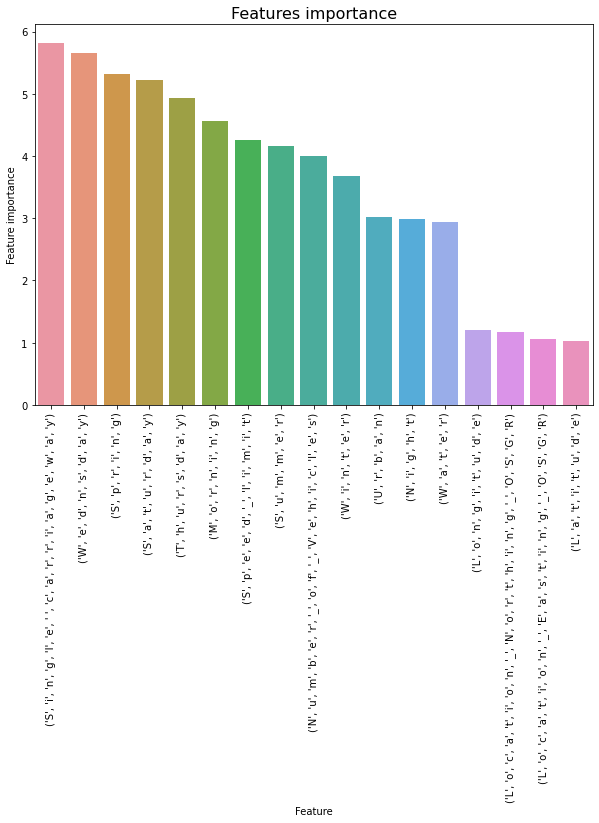

In [48]:
#Dataframe containing features in the training set and the mmodel feature imporacnce
tmp = pd.DataFrame({'Feature': X_train_sm, 'Feature importance': feature_importances})

#fort the feature importance in descending order 
tmp = tmp.sort_values(by='Feature importance',ascending=False)

#create the bar plot 
plt.figure(figsize = (10,7))
plt.title('Features importance',fontsize=16)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

The feature importance is pretty much the same with what we got from the previous model.
Now, let's save the trained model in memory. 

In [27]:
#Save the model into the folder     
dump(oversamp_rfc_grid.best_estimator_, 'models/rfc-smote.joblib')

['models/rfc-smote.joblib']

### XGBOOST Classifier - Oversampling 

The last model we are going to perform is a XGBOOST Clasifier which is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. 

As for the previous model, we are going to train the XGBOOST Classifier on the transformed balananced training set. 

In [24]:
#instantiate the model 
xgb_oversamp = XGBClassifier(random_state=42, n_jobs=-1)

#set the hyperparameters to be tuned 
param_grid = [
    {
        "max_depth": [10, 15, 20, None],
        "min_child_weight": [5, 10],
        "n_estimators": [200, 400, 600]
    }]


# we'll use 5-fold cross-validation with a randomised 6 models 
xgb_oversamp_grid = RandomizedSearchCV(xgb_oversamp, param_grid, cv=5, n_iter=6,
                              scoring='f1_macro',
                              return_train_score=True, n_jobs=-1)

#fit the model on the oversampled training set 
start = time.time()
xgb_oversamp_grid.fit(X_train_sm, y_train_sm)
end = time.time() - start
print(f"Took {end} seconds")

/opt/anaconda3/envs/NicholasEnv/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:04:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614844528294/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Took 4485.5742337703705 seconds


Below, we can see the best hyperparameters combination which has been able to achieve the best F-score of approximately **0.8098**, whihch again is higher that the one obtained assigning weights to the target classes but still lower than the one achieved by the previous model. 

In [26]:
#best parameters 
xgb_oversamp_grid.best_params_

{'n_estimators': 600, 'min_child_weight': 5, 'max_depth': 15}

In [27]:
#best score obtained 
xgb_oversamp_grid.best_score_

0.8098421541619192

Again, we can check the feature importances also for the XGBOOST Classifier and notice that for this model the most important features actually changed as well as the least important once. For instance, we have aways had the location measuraments such as longitute and latitute at the top of the list, while now they are all at the bottom. On the other hand, the days of the week increased their importance, while other features such as the speed limit and number of vehicles kept their position high in the list. 

In [57]:
#xgboost feature importance 
feature_importances = xgb_oversamp_grid.get_booster().get_score(importance_type="gain")

#print them along side the name of the feature
{k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)}

{'Speed_limit': 5.824494828049703,
 'Single carriageway': 5.6534056461808495,
 'Thursday': 5.316381273735141,
 'Number_of_Vehicles': 5.222301180884463,
 'Saturday': 4.926256030379843,
 'Wednsday': 4.557409903749438,
 'Night': 4.265127852719993,
 'Urban': 4.154312967853216,
 'Morning': 4.00187961941394,
 'Water': 3.680801324562276,
 'Summer': 3.027928343892655,
 'Winter': 2.9851554997107845,
 'Spring': 2.947420204858978,
 'Location_Northing_OSGR': 1.2008407052212031,
 'Location_Easting_OSGR': 1.17019346716191,
 'Latitude': 1.0607460177977155,
 'Longitude': 1.028538575499992}

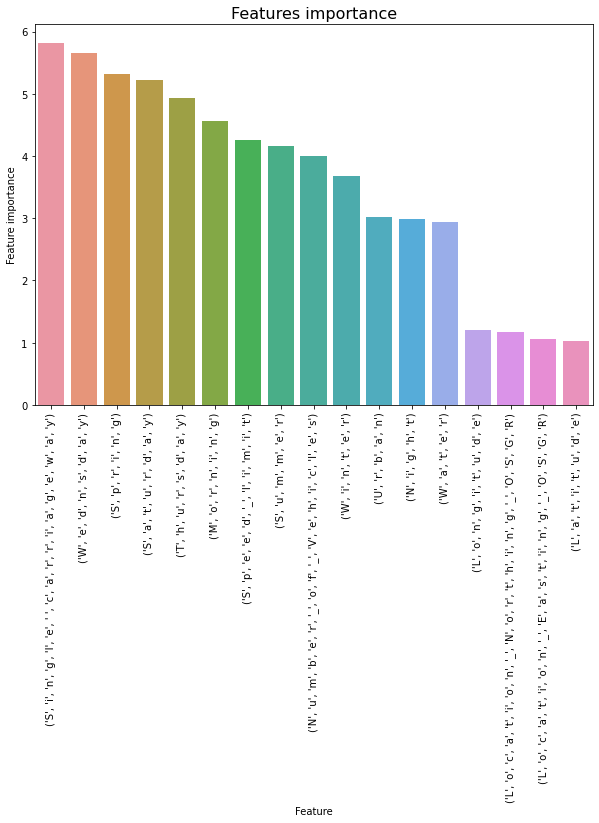

In [58]:
#Dataframe containing features in the training set and the mmodel feature imporacnce
tmp = pd.DataFrame({'Feature': X_train_sm, 'Feature importance': feature_importances})

#fort the feature importance in descending order 
tmp = tmp.sort_values(by='Feature importance',ascending=False)

#create the bar plot 
plt.figure(figsize = (10,7))
plt.title('Features importance',fontsize=16)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

Let's save the model in memory. 

In [28]:
#Save the model into the folder     
dump(xgb_oversamp_grid.best_estimator_, 'models/xgb-smote.joblib')

['models/xgb-smote.joblib']

## Model evaluation

We got four models so far: a Logistic Regression, th esecond Random Forest Classifier trained assigning weights to the target classes, a Random forest Classifier trained using oversampling and a XGBOOST Classifier trained using oversampling. 

(Because of a low computer computational power, I have not been able to use undersampling neither inside or outside the pipeline). 

Hence, we can now use all of the trained models for predicting the accident severity from the testing set and see what are their performance on unseen data as well as confronting the results with the calculated baseline: 

* **Precision: 0.262**

* **Recall: 0.333**

* **F-score: 0.294**

In [11]:
#logistic regression - class weights
lr_wt_grid = load('models/cw-lr.joblib')

#random forest classifier - class weights
rfc_cw_grid2 = load('models/cw-rf-clf2.joblib')

#random forest classifier - oversampling 
oversamp_rfc_grid = load('models/rfc-smote.joblib')

#xgboost classifier - oversampling 
xgb_oversamp_grid = load('models/xgb-smote.joblib')

In [12]:
#Create a function to evalue the model using Precision, Recall and F1 macro score 
def get_evaluation (model, X_test, y_test):
    
    #make the predictions 
    y_hat = model.predict(X_test)

    # macro-averaged precision, recall and f-score
    p, r, f, s = precision_recall_fscore_support(y_test, y_hat, average="macro")
    print(f"{model}:\n")
    print(f"Precision: {p}")
    print(f"Recall: {r}")
    print(f"F score: {f}")

### Logist Regression - Class Weights - Evaluation 

The Logistic regression F-score on the testing set is similar with the one we got on the training set and overall better than the baseline. Although we can  see that the Recall is higher than the Precision, which might be considered as a good feature since we are predicting something quite important as the accident severity. 

In [13]:
#predict the accident severity on the testing set and retrive the precision, recall and fscore 
get_evaluation(lr_wt_grid, X_test_sfm, y_test)

LogisticRegression(C=0.01, class_weight='balanced', multi_class='multinomial',
                   n_jobs=-1, random_state=42):

Precision: 0.371049143191434
Recall: 0.47509848448100916
F score: 0.3306207343199366


Furthermore, from the confusion matrix it is visible how the model predicted a plenty number of times either as slight or serioius an accident that was actually fatal as well as slight an accident that was serious. 

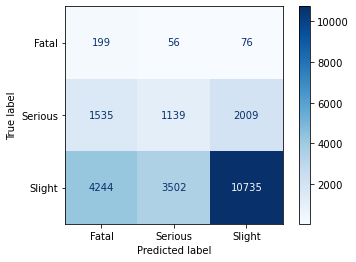

In [14]:
#plot the confusion matrix
plot_confusion_matrix(lr_wt_grid, X_test_sfm, y_test, cmap=plt.cm.Blues)

### Random Forest - Class Weights - Evaluation 

The Random Forest model we used assigning class weights got again a similar perfornace as in the training set, which is higher than the baseline. Though, both of the F-score and precision are better than the ones for the Logistic Regression, the recall is quite lower. 

In [15]:
#predict the accident severity on the testing set and retrive the precision, recall and fscore 
get_evaluation(rfc_cw_grid2, X_test_sfm, y_test)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [15, 20],
                         'n_estimators': [700, 800]},
             return_train_score=True, scoring='f1_macro'):

Precision: 0.38920371686458144
Recall: 0.3991713468844791
F score: 0.38911197948010984


We can have a better view of the performance of the model looking at the confusion matrix. Again, we can see how worst the recall is for this model compared with the previous one. Furthermore, the model appears to consused when an accident is serious and slight, in fact, comparing it with the Logistic Regression, it more times wrongly predictied an accident to be slight when it was actually serious. Same this happend when the accident was actaully Fatal.  

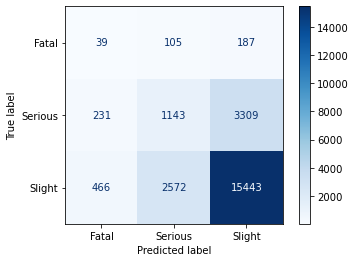

In [17]:
#plot the confusion matrix
plot_confusion_matrix(rfc_cw_grid2, X_test_sfm, y_test, cmap=plt.cm.Blues)

### Random Forest - Oversampling - Evaluation 

The Random Forest trained using the oversampling technique performed in a very similar way as the Random Forest with class weights, perhaps a little bit worst. In fact, while the recall is pretty much the same, it got a worst precision and F-score. 

In [71]:
#predict the accident severity on the testing set and retrive the precision, recall and fscore 
get_evaluation(oversamp_rfc_grid, X_test_sfm, y_test)

RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=700,
                       n_jobs=-1, random_state=42):

Precision: 0.37505456546146637
Recall: 0.3950566136329545
F score: 0.3782061059686678


Comparing this model confusion matrix with the previous one, we can actually see how this model and the previous one are very much similar between each other. Hence, training the same algorithm using oversampling and class weights gave very close results. 

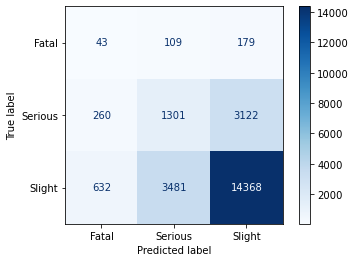

In [72]:
#plot the confusion matrix
plot_confusion_matrix(oversamp_rfc_grid, X_test_sfm, y_test, cmap=plt.cm.Blues)

### XGBOOST - Oversampling - Evaluation 

Lastly, the XGBOOST tarined using oversampling techinque did not perform quite well, with all the three scores lower than the two Random Forests, and only the F-score higher than the Logistic Regression one, but with both precision and recall considerably lower. 

In [73]:
#predict the accident severity on the testing set and retrive the precision, recall and fscore 
get_evaluation(xgb_oversamp_grid, X_test_sfm, y_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None):

Precision: 0.362010666597499
Recall: 0.36383363763806104
F score: 0.3626732511990907


We can see the bad performance of the XGBOOST from the confusion matrix below. Furthermore, it is quite worrying to see that the model well predicted a fatal accident only 8 times out of 331, which represents only the 2.41% of the times. 

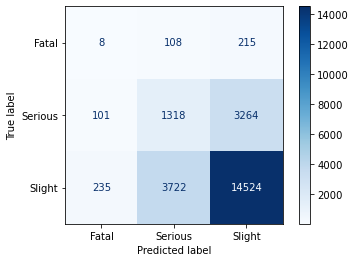

In [74]:
#plot the confusion matrix
plot_confusion_matrix(xgb_oversamp_grid, X_test_sfm, y_test, cmap=plt.cm.Blues)

## Discussion of evaluation results

From the models evaluation we have seen how all the four trained models performed on the testing set, and more or less we got similar results than the ones obtained using cross validation on the training set. 

Although we have not achieved great results, at least all the models achieved a better result than the baseline. However, if I had to choose the most appropriate model I would probably go for the Logistic Regression. 

In fact, since our business goal is to improve the road safety in the UK, we want the model to be as more conservative as possible, prefering a a high recall rather than a high precision and the Logistic Regression is the one that got the highest recall score by far with a value of 0.4750. 

Moreover, it has been the one that better understood when an accident was fatal. Also, even though other models have been better in understand if an accident was serious, if we summed up the times the Logistic Regression predicted either fatal or serious when an accident was actually serious, it would get the highest value. Hence, it is by far the most conservative model, whose is more incline to predict an accident as serious or fatal than the other models. Of course, this will lead to errors in predicting possible slight accident as more serious than they really might be, but as stated earlier, we want to be sure to improve as much as possible the road safety in the country and this represents the most severe way to achieve this. Though, since the F-score of the model is not that high, the algorithm will naturally lose some strength down the road, but this could be seen as an even stronger argument to prefer the Logistic Regression, since all the four models performed quite poorly.

## Possible future improvements

In order to improve the model's performance we would need more data for the minority classes, fatal and serious. We could for instance use data for the previous years or waiting for the next year data. 

Despite of that, another improvement might be brought in by the use of a more powerfull machine where to train the algorithm on, in fact, we could not use very complex models such as either Artificial Neural Networks or Voting Ensemble algorithms, which are more capable to capture the very small details in the dataset, perhaps being able to better differentiate between the magority and the minority classes. 

Lastly, a possible improvement might be to imvestigate deeper on what are the causes of cars' accident in the UK, trying to include more features in the dataset, which might be able to better explain the target variable than now.  

## Possible scenarios to deploy the models in real-world business scenarios

Consisent with the business goal of this project, a possible real-world business scenarios to use and deploy the model would be either for no-profit enities such as the Goverment, in order to improve the road safety in the country to increase the quality of life of their citizens, or for private companies and tech start-ups who might be offer this technology to the Goverment and be paid for it. In the latter case, the advange for the Goverment would be that it might not have the resources and capabilities to develop and mantain this kind of techonolgy, something that private entities have, thereby outsourcing would represent a valid alternative to take into account.  